### Library loading

In [2]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
import warnings
import yaml
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scipy.sparse as sp
import statsmodels.api as sm
import scanpy as sc
import cellrank as cr
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot 
import scanpy.external as sce
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
warnings.filterwarnings('ignore')
import scvelo as scv
import plotly.express as px
import plotly.io as pio
import itertools
import decoupler as dc
import sys
pio.renderers.default = "notebook_connected"
import random
random.seed(1)


In [3]:
homeDir = os.getenv("HOME")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")


from CleanAdata import *
from SankeyOBS import *


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = "".join(os.path.basename(globals()["__vsc_ipynb_file__"]).split(".")[:-1])

# Load Metacells anndata

In [5]:
n_neighb = 30
n_pcs = 5

In [6]:
CombinedAdata = sc.read_h5ad("./2_TrajectoriesAdata.h5ad")

# Cellrank Overview

<div>
  <img src="https://cellrank.readthedocs.io/en/latest/_images/100_cellrank_overview.png" width="800">
</div>

<div>
  <p>
    <strong>Reference:</strong> 
    <a href="https://www.nature.com/articles/s41592-024-02303-9">CellRank 2: unified fate mapping in multiview single-cell data</a>
  </p>
</div>

<div style="padding-top: 10px; font-size: 20px;">
    <p>
        Cellrank allows to easily convert directed (e.g., pseudotime) and/or undirected (static transcriptional similarity) neighbor graphs into <strong>cell–cell transition matrices</strong>.<br>
        Cell–cell transition matrices derived from diverse modalities can be combined to model the cells' relationships and their hierarchies.<br><br>
        The obtained model can be used to:<br>
        <ul>
            <li>Compute Macrostates </li>
            <li>Compute fate probabilities</li>
            <li>Perform other downstream tasks</li>
        </ul>
    </p>
</div>


<div class="alert alert-block alert-info">
  <b>NOTE: Here we will use CellRank capabilities to:</b>
  
  * Refine the trajectories obtained from the previous notebook <a href="./2_Palantir.ipynb"> (2_Palantir.ipynb)</a>
    *  Combining **Palantir pseudotime**, to **transcriptional similarity** and **Pluripotency score**
  * Formalize fate probabilities
  * Compute putative lineage-drive genes


# 1. **CytoTRACE** will generate our potency score to combine with palantir pseudotime

<div>
  <img src="https://cytotrace.stanford.edu/CytoTRACEframework2.png" width="800">
</div>


<div>
  <p>
    <strong>Reference:</strong> 
    <a href="https://www.science.org/doi/10.1126/science.aax0249">Single-cell transcriptional diversity is a hallmark of developmental potential</a>
  </p>
</div>


<div style="padding-top: 10px; font-size: 20px;">
    <p>
        CytoTRACE relies on the assumption that:<br> 
        <ul>
            <li>Cells expressing <strong>more genes</strong> are likely <strong>less differentiated</strong> </li>
            <li>Less differentiated cells <strong>must be present</strong> in the analysed SC dataset</li>
        </ul>
    </p>
</div>

In [58]:


from cellrank.kernels import ConnectivityKernel
from cellrank.kernels import CytoTRACEKernel
from cellrank.kernels import PseudotimeKernel

#Cytotrace
adataCR = CombinedAdata.copy()

adataRaw = adataCR.copy()
adataRaw.X = adataRaw.layers["median"].copy()

adataCR.raw = adataRaw.copy()

adataCR.layers["spliced"] = adataCR.layers["median"].copy()
adataCR.layers["unspliced"] = adataCR.layers["median"].copy()
scv.pp.moments(adataCR, n_pcs=None, n_neighbors=None, use_highly_variable=False)
ctk = CytoTRACEKernel(adataCR).compute_cytotrace(use_raw=True).compute_transition_matrix(threshold_scheme="soft", nu=0.5)


computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


  0%|          | 0/3200 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


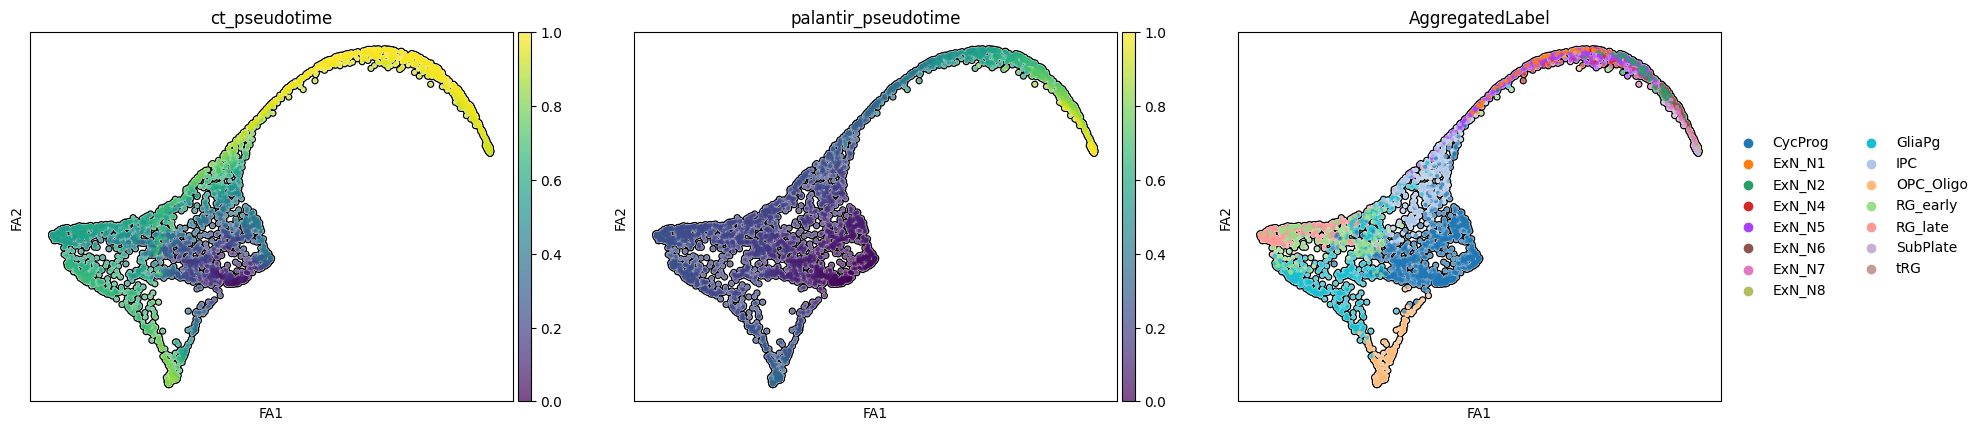

In [59]:
sc.pl.draw_graph(adataCR, color=["ct_pseudotime","palantir_pseudotime","AggregatedLabel"], add_outline=True)


# 2. Next we combine 
* **CytoTRACE** output  <span style="color: #ff6347;">**_(CTK)_**</span>
* already available **Palantir pseudotime** from previous notebook <span style="color: #566ce8;">**_(PK)_**</span>
* **transcriptional similarity** <span style="color: #1ed42d;">**_(CK)_**</span>

In [60]:
# connectivities
ck = ConnectivityKernel(adataCR).compute_transition_matrix()

# dpt
pk = PseudotimeKernel(adataCR, time_key="palantir_pseudotime").compute_transition_matrix()

combined_kernel = .8 * pk + .2 * ctk + .1 * ck 
combined_kernel

  0%|          | 0/3200 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


(0.8 * PseudotimeKernel[n=3200, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * CytoTRACEKernel[n=3200, dnorm=False, scheme='soft', b=10.0, nu=0.5] + 0.1 * ConnectivityKernel[n=3200, dnorm=True, key='connectivities'])

# 3. Finally we use GPCCA (estimator) to Macrostates and cell-cell dynamics from the **combined_kernel**

In [61]:
from cellrank.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[kernel=(0.727 * PseudotimeKernel[n=3200] + 0.182 * CytoTRACEKernel[n=3200] + 0.091 * ConnectivityKernel[n=3200]), initial_states=None, terminal_states=None]


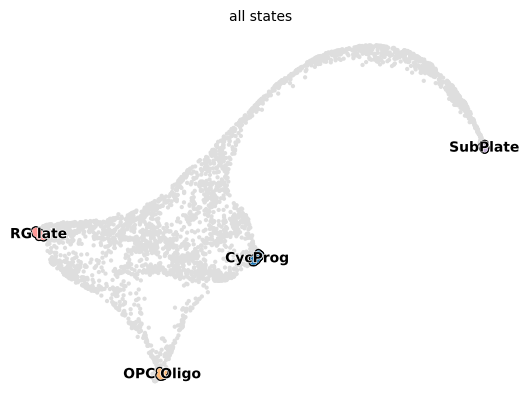

In [62]:
g.fit(n_states=4, cluster_key="AggregatedLabel")
g.plot_macrostates(which="all", basis="X_draw_graph_fa")

### Here we <span style="color: #ff6347;">manually</span> assign initial and terminal states from the detected macrostates

  0%|          | 0/3 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


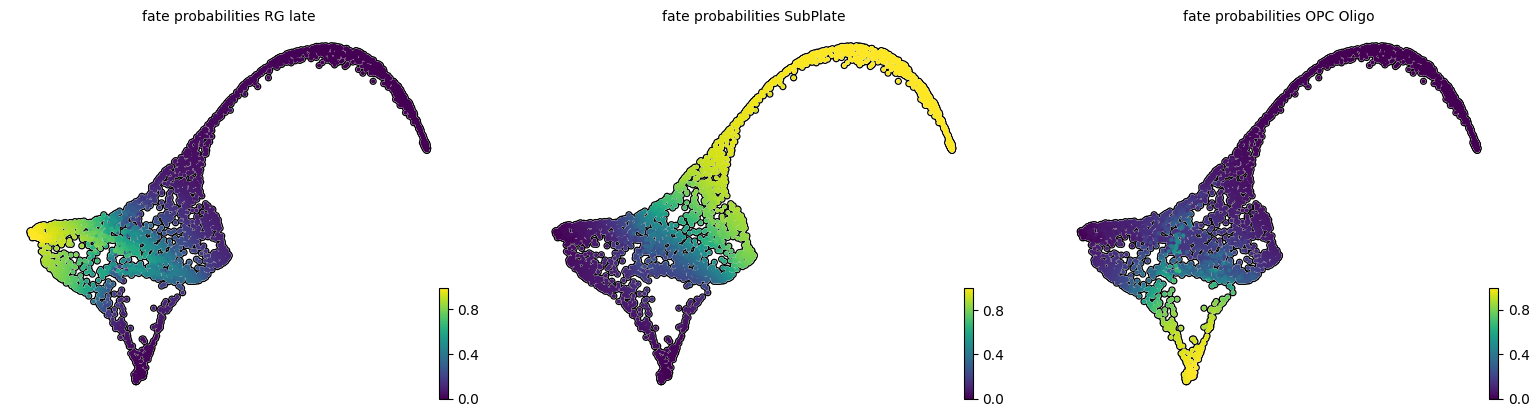

In [ ]:
g.set_initial_states("CycProg")
g.set_terminal_states(["RG_late", "SubPlate","OPC_Oligo"])
g.compute_fate_probabilities()
g.plot_fate_probabilities(basis="X_draw_graph_fa", same_plot=False, add_outline=True)

In [ ]:
["RG_late", "SubPlate","OPC_Oligo"]

AnnData object with n_obs × n_vars = 3200 × 16324
    obs: 'kmeans_clusters', 'AggregatedClass', 'AggregatedLabel', 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'Auth_Assay_formatted', 'scDblFinder.class', 'palantir_pseudotime', 'palantir_entropy', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes', 'macrostates_fwd', 'init_states_fwd', 'init_states_fwd_probs', 'term_states_fwd', 'term_states_fwd_probs'
    var: 'ct_gene_corr', 'ct_correlates', 'mean expression'
    uns: 'AggregatedClass_colors', 'AggregatedLabel_colors', 'Auth_Sample.ID_colors', 'DM_EigenValues', 'draw_graph', 'neighbors', 'palantir_waypoints', 'rank_genes_groups', 'ct_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'macrostates_fwd_colors', 'coarse_fwd', 'init_states_fwd_colors', 'term_states_fwd_colors'
    obsm: 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_draw_graph_fa', 'X_pca', '

# 4. No we can compute **lineage drivers**

### Lineage driver genes are obtained by <span style="color: #ff6347;">correlating</span> the fate probabilities with gene expression with gene-expression through `compute_lineage_drivers()` function

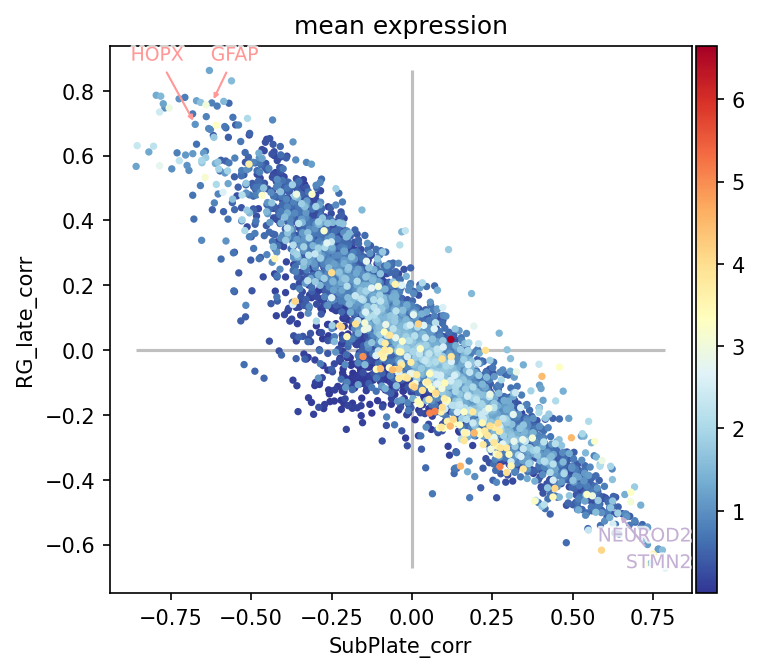

In [68]:
# compute driver genes
driver_df = g.compute_lineage_drivers()

# define set of genes to annotate
SubPlate_genes = ["STMN2", "NEUROD2"]
RG_late_genes = ["GFAP", "HOPX"]



genes_oi = {
    "SubPlate": SubPlate_genes,
    "RG_late": RG_late_genes,
}

# make sure all of these exist in AnnData
assert [
    gene in adataCR.var_names for genes in genes_oi.values() for gene in genes
], "Did not find all genes"

adataCR.var["mean expression"] = adataCR.X.A.mean(axis=0)


# visualize in a scatter plot
g.plot_lineage_drivers_correlation(
    lineage_x="SubPlate",
    lineage_y="RG_late",
    adjust_text=True,
    gene_sets=genes_oi,
    color="mean expression",
    legend_loc="none",
    figsize=(5, 5),
    dpi=150,
    fontsize=9,
    size=50,
)

In [ ]:
model = cr.models.GAMR(adataCR, n_knots=6, smoothing_penalty=10.0)


  0%|          | 0/40 [00:00<?, ?gene/s]

[0]PETSC ERROR: 

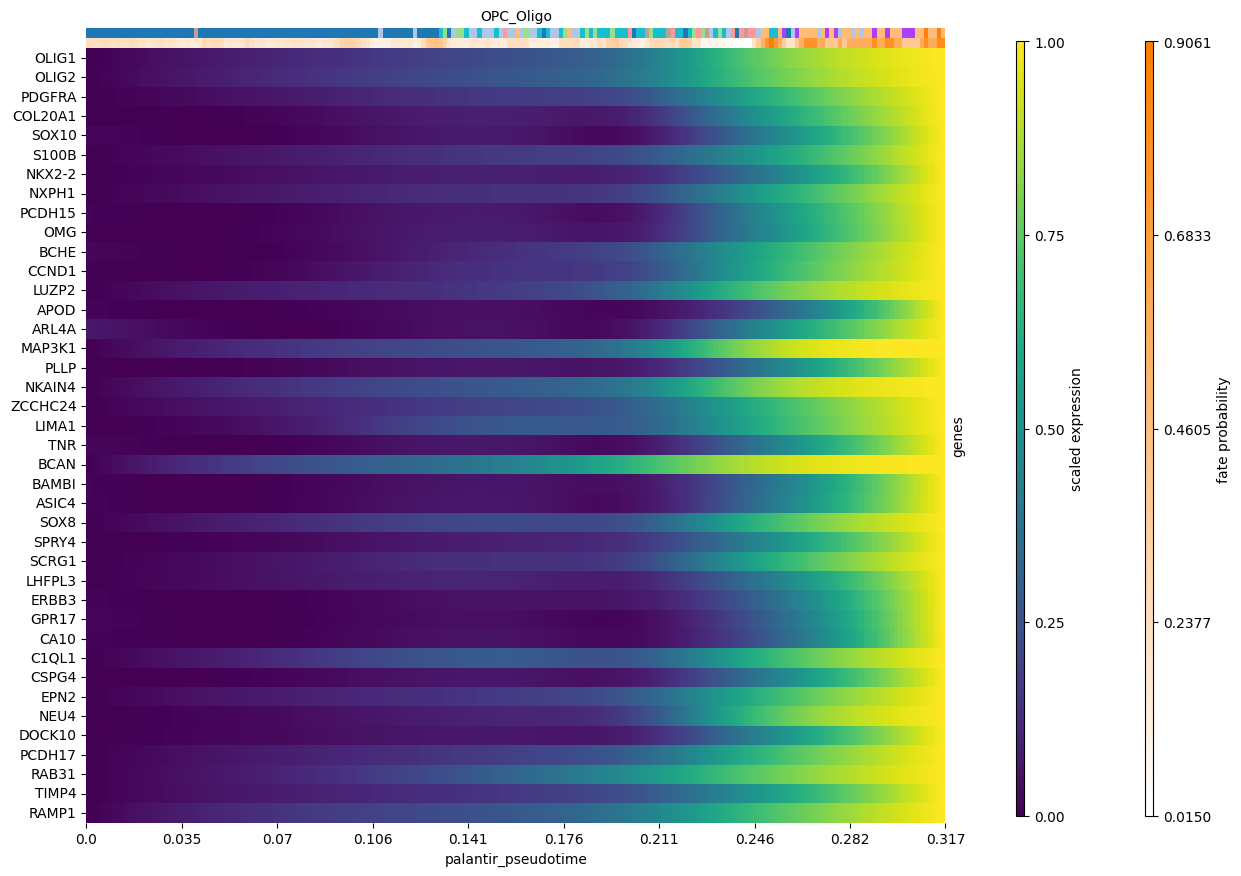

In [ ]:
# compute putative drivers for the Beta trajectory
OPC_Oligo_drivers = g.compute_lineage_drivers(lineages="OPC_Oligo")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="OPC_Oligo",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=OPC_Oligo_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

  0%|          | 0/40 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


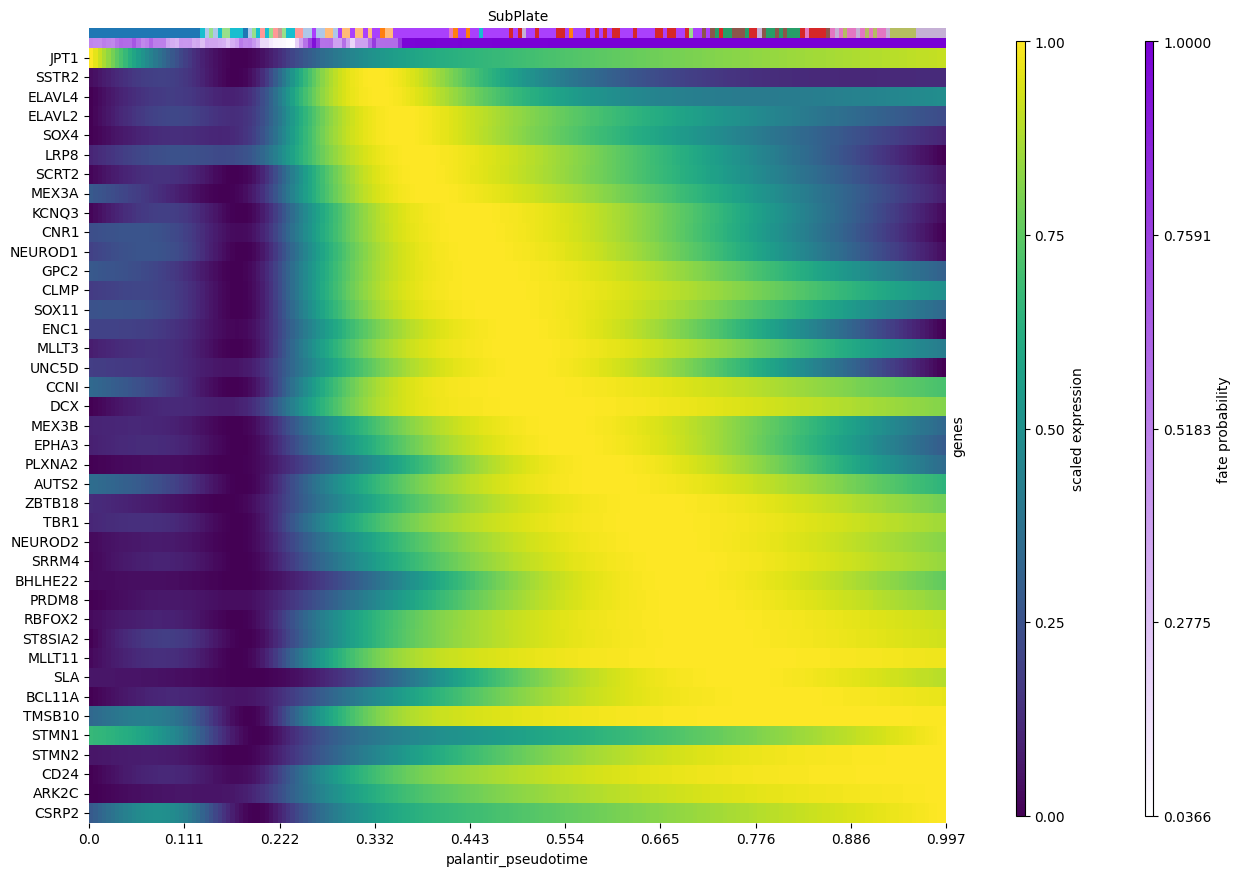

In [ ]:
# compute putative drivers for the Beta trajectory
SubPlate_drivers = g.compute_lineage_drivers(lineages="SubPlate")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="SubPlate",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=SubPlate_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

  0%|          | 0/40 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


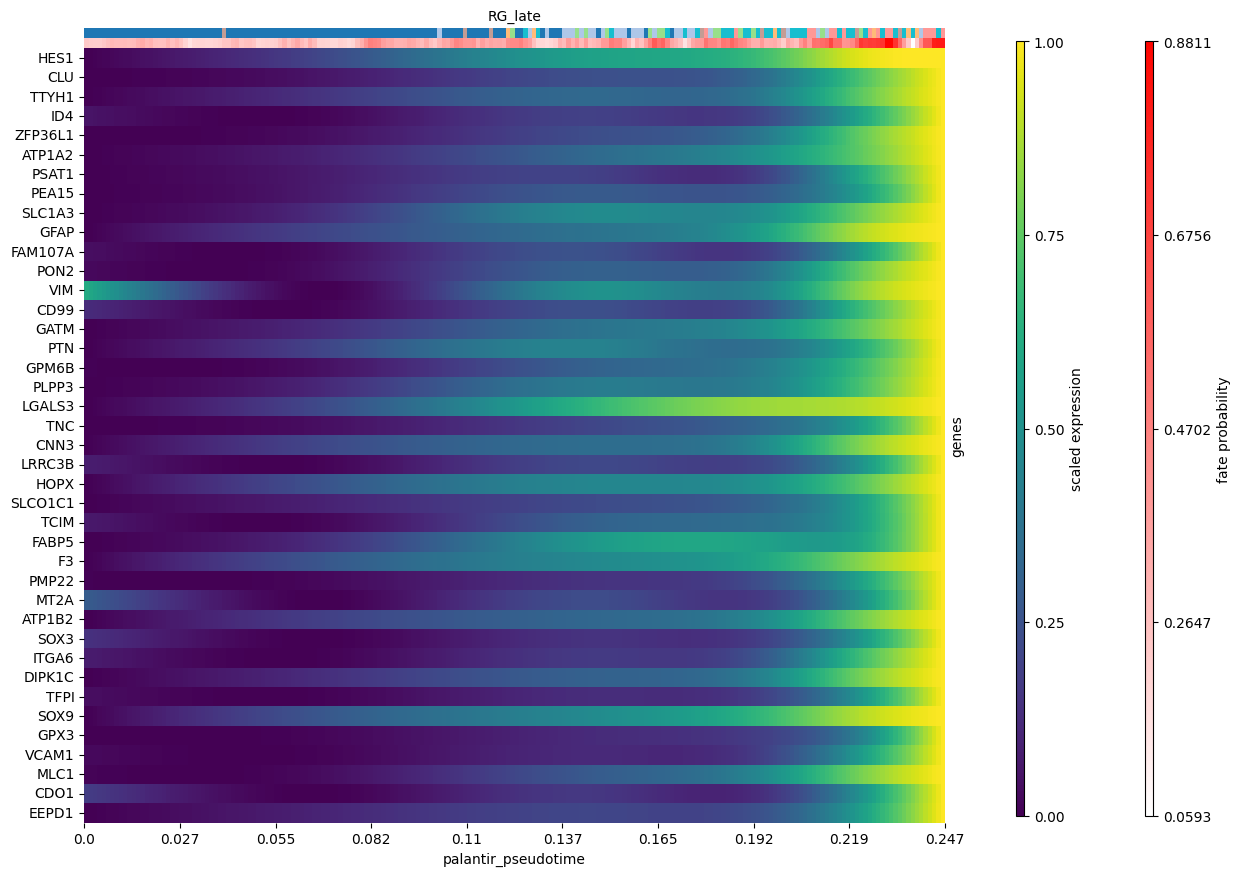

In [ ]:
# compute putative drivers for the Beta trajectory
RG_late_drivers = g.compute_lineage_drivers(lineages="RG_late")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="RG_late",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=RG_late_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

In [ ]:
# Save the estimator
g.write("./GPCCA.pickle")

In [ ]:
# Save anndata
adataCR.write_h5ad("./3_CellrankAdata.h5ad")